# Programming Exercise 8: Anomaly Detection and Recommender Systems
## Machine Learning
### Introduction
In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

### Files included in this exercise
* `ex8.ipynb` - Python script that steps you through the exercise. 
* `ex8_utils.py` - All necessary functions, classes and solutions for the exercises.
* `ex8_data/ex8data1.mat` - First Example Dataset for anomaly detection.
* `ex8_data/ex8data2.mat` - Second Example Dataset for anomaly detection.
* `ex8_data/ex8_movies.mat` - Movie Review Dataset.
* `ex8_data/ex8ovieParams.mat` - Parameters Provided for debugging.
* `ex8_data/movie_ids.txt` - List of movies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from ex8_utils import *
import warnings

# Setup environment variables

%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1 Anomaly detection
In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)},..., x^{(m)} \}$. You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. 
The first part will visualize the dataset as shown in <b>Figure 1</b>.
<img src="figure1.png" height="50%" width="50%">

### 1.1 Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data's distribution.
Given a training set $\{x^{(1)},..., x^{(m)} \}$ (where $x^{(i)} \in{\mathbb{R}^n}$ ), you want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1...n$, you need to find parameters $\mu_i$ and $\sigma^2_i$
that fit the data in the i-th dimension $\{x^{(1)},..., x^{(m)} \}$ (the i-th dimension of each example).

The Gaussian distribution is given by

$$
p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}} ,
$$

where $\mu$ is the mean and $\sigma^2$ controls the variance.

### 1.2 Estimating parameters for a Gaussian
You can estimate the parameters, ($\mu_i$, $\sigma^2_i$), of the i-th feature by using the following equations. To estimate the mean, you will use:

$$
\mu_i = \frac{1}{m} \sum^{m}_{j=1}{x^{(j)}_i}, 
$$

and for the variance you will use:

$$
\sigma^2_i = \frac{1}{m} \sum^{m}_{j=1}{(x^{(j)}_i - \mu_i)^2}, 
$$

Your task is to complete the code in <b>estimate_gaussian</b>. This function takes as input the data matrix $X$ and should output an $n$-dimension vector $\text{mu}$ that holds the mean of all the $n$ features and another $n$-dimension vector $\text{sigma2}$ that holds the variances of all the features. You can implement this using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer). 

Once you have completed the code in <b>estimate_gaussian</b>, the next part will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to <b>Figure 2</b>. 
<i>From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.</i>

<b> Figure 2: The Gaussian distribution contours of the distribution fit to the dataset.</b>

<img src="figure2.png" align="left" height="50%" width="50%">

Visualizing example dataset for outlier detection.


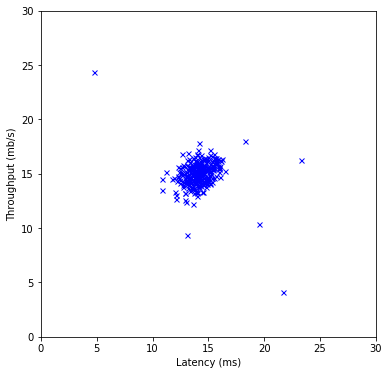

	Figure 1: The first dataset


In [2]:
# ================== Part 1: Load Example Dataset  ===================
# We start this exercise by using a small dataset that is easy to visualize.

# Our example case consists of 2 network server statistics acrossseveral machines: the latency and throughput of each machine.
# This exercise will help us find possibly faulty (or very fast) machines.

print('Visualizing example dataset for outlier detection.')

# The following command loads the dataset. 
data = io.loadmat('ex8_data/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

# Visualize the example dataset
plt.figure(figsize=(6,6))
plt.plot(X[:,0], X[:,1], 'bx', ms=5)
plt.axis([0, 30, 0, 30])

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()
print('\tFigure 1: The first dataset')

Visualizing Gaussian fit.


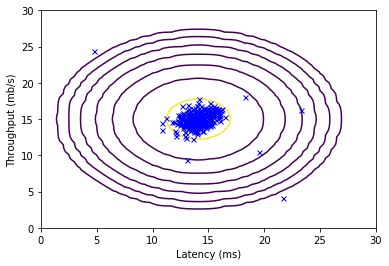

In [3]:
# ================== Part 2: Estimate the dataset statistics ===================
# For this exercise, we assume a Gaussian distribution for the dataset.
# We first estimate the parameters of our assumed Gaussian distribution, 
# then compute the probabilities for each of the points and then visualize 
# both the overall distribution and where each of the points falls in 
# terms of that distribution.
print('Visualizing Gaussian fit.')

# Estimate my and sigma2
mu, sigma2 = estimate_gaussian(X)

# %  Returns the density of the multivariate normal at each data point (row) 
# %  of X
p = multivariate_gaussian(X, mu, sigma2)
# p = multivariateGaussian(X, mu, sigma2);


# Visualize the fit
visualize_fit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### 1.3 Selecting the threshold, ε

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the $F_1$ score on a cross validation set.

You should now complete the code in <b>select_threshold</b>. For this, we will use a cross validation set $\{(x^{(1)}_\text{cv}, y^{(1)}_\text{cv}), ..., (x^{(m_\text{cv})}_\text{cv}, y^{(m_\text{cv})}_\text{cv})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p(x^{(i)}_\text{cv})$. The vector of all of these probabilities $p(x^{(1)}_\text{cv})$,...,$p(x^{(m)}_\text{cv})$ is passed to <b>select_threshold</b> in the vector $\text{pval}$. The corresponding labels $y^{(1)}_\text{cv}$,...,$y^{(m_\text{cv})}_\text{cv}$ is passed to the same function in the vector $\text{yval}$.

The function <b>select_threshold</b> should return two values; the first is the selected threshold $\epsilon$. If an example $x$ has a low probability $p(x) < \epsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you're doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$
F1 = \frac{2 . prec . rec}{prec + rec}, 
$$

You compute precision and recall by:

$$
prec = \frac{tp}{tp + fp} 
$$

$$
rec = \frac{tp}{tp + fn}, 
$$

where
* $tp$ is the number of true positives: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.
* $fp$ is the number of false positives: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.
* $fn$ is the number of false negatives: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.
    
In the provided code <b>select_threshold</b>, there is already a loop that will try many different values of $\epsilon$ and select the best $\epsilon$ based on the $F_1$ score.

You should now complete the code in <b>select_threshold</b>. You can implement the computation of the $\text{F1}$ score using a for-loop over all the cross validation examples (to compute the values $tp$, $fp$, $fn$). You should see a value for epsilon of about $\text{8.99e-05}$.

Once you have completed the code in <b>select_threshold</b>, the next step will run your anomaly detection code and circle the anomalies in the plot (<b>Figure 3</b>).

<img src="figure3.png" height="50%" width="50%">


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000

   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)




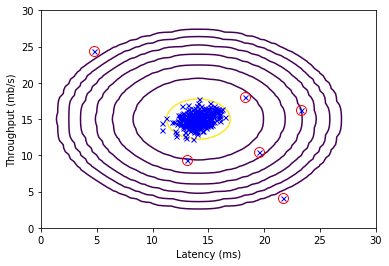

In [4]:
warnings.filterwarnings('ignore') #ignore some calculate warnings for more clear display

# ================== Part 3: Find Outliers ===================
pval = multivariate_gaussian(Xval, mu, sigma2)

epsilon, F1 = select_threshold(yval, pval)
# [epsilon F1] = selectThreshold(yval, pval);
print('Best epsilon found using cross-validation: %e' %epsilon)
print('Best F1 on Cross Validation Set:  %f\n' %F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)\n\n')

# Find the outliers in the training set and plot the
outliers = np.where(p < epsilon)[0]
# Draw a red circle around those outliers
visualize_fit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', lw=2, ms=10, mfc='None')
plt.show()

### 1.4 High dimensional dataset
The last part of the first exercise will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by $11$ features, capturing many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma^2_i$), evaluate the probabilities for both the training data $X$ from which you estimated the Gaussian parameters, and do so for the the cross-validation set $\text{Xval}$. Finally, it will use <b>select_threshold</b> to find the best threshold $\epsilon$. You should see a value epsilon of about $\text{1.38e-18}$, and $117$ anomalies found.

In [5]:
warnings.filterwarnings('ignore')

# ================== Part 4: Multidimensional Outliers ===================
# We will now use the code from the previous part and apply it to a harder problem in which more features 
# describe each datapoint and only some features indicate whether a point is an outlier.

# Loads the second dataset. 
data = io.loadmat('ex8_data/ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

# Apply the same steps to the larger dataset
mu, sigma2 = estimate_gaussian(X)

# Training set 
p = multivariate_gaussian(X, mu, sigma2)

# Cross-validation set
pval = multivariate_gaussian(Xval, mu, sigma2)

# Find the best threshold
epsilon, F1 = select_threshold(yval, pval)

print('Best epsilon found using cross-validation: %e' %epsilon)
print('Best F1 on Cross Validation Set:  %f\n' %F1)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)\n')
print('Outliers found: %d' %sum(p < epsilon))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385

   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)

Outliers found: 117


## 2 Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 

In the next parts of this exercise, you will implement the function <b>cofi_cost_func</b> that computes the collaborative fitlering objective function and gradient. After implementing the cost function and gradient, you will use <b>fmincg</b> to
learn the parameters for collaborative filtering.

### 2.1 Movie ratings dataset

The next part of the script will load the dataset <b>ex8_movies.mat</b>, providing the variables $Y$ and $R$ 
The matrix $Y$ (a $\text{num_movies} \times \text{num_users}$ matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix $R$ is an binary-valued indicator matrix, where $R(i,j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i,j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i,j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix $Y$, the script will compute the average movie rating for the first movie (Toy Story) and output the average rating to the screen.

Throughout this part of the exercise, you will also be working with the matrices, $X$ and $\text{Theta}$:

$$
\left. \begin{array}{lr}
    X = \left[ \begin{array}{ccc}
        - & (x^{(1)})^T & - \\
        - & (x^{(2)})^T & - \\
          & \vdots & \\
        - & (x^{(n_m)})^T & - 
    \end{array} \right] ,
    &
    \text{Theta} = \left[ \begin{array}{ccc}
        - & (\theta^{(1)})^T & - \\
        - & (\theta^{(2)})^T & - \\
          & \vdots & \\
        - & (\theta^{(n_u)})^T & - 
    \end{array} \right] .
\end{array}\right.
$$

The $i$-th row of $X$ corresponds to the feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of $\text{Theta}$ corresponds to one parameter vector $\theta^{(j)}$ , for the $j$-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in{\mathbb{R}^{100}}$ and $\theta^{(i)} \in{\mathbb{R}^{100}}$.
Correspondingly, $X$ is a $n_m \times 100$ matrix and $\text{Theta}$ is a $n_u \times 100$ matrix.

Loading movie ratings dataset.

Average rating for movie 1 (Toy Story): 3.878319 / 5


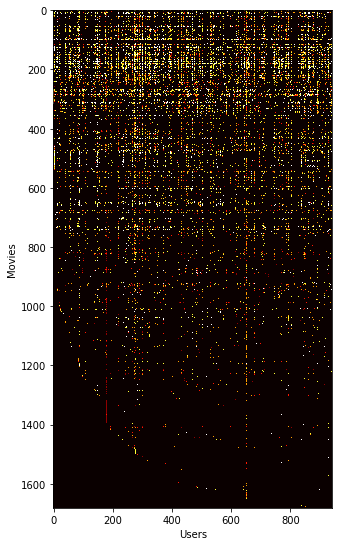

In [6]:
# =============== Part 1: Loading movie ratings dataset ================
# You will start by loading the movie ratings dataset to understand the structure of the data.
print('Loading movie ratings dataset.\n')

# Load data
data = io.loadmat('ex8_data/ex8_movies.mat')
Y = data['Y'] # shape(1682, 943), containing ratings (1-5) of 1682 movies on 943 users
R = data['R'] # shape(1682, 943), where R(i,j) = 1 if and only if user j gave a rating to movie i
    
# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' \
      %np.mean(Y[0, np.where(R[0, :]==1)]))

# Visualize the ratings matrix
plt.figure(figsize=(5,10))
plt.imshow(Y, cmap='hot')
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

## 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of $n$-dimensional parameter vectors $x^{(1)}, ..., x^{(n_m)}$ and $\theta^{(1)}, ..., \theta^{(n_u)}$ , where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$ . Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in <b>cofi_cost_func</b> to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are $X$ and $\text{Theta}$. In order to use an off-the-shelf minimizer such as <b>fmincg</b>, the cost function has been set up to unroll the parameters into a single vector params. You had previously used the same vector unrolling method in the neural networks programming exercise.

### 2.2.1 Collaborative filtering cost function
The collaborative filtering cost function (without regularization) is given by

$$
\large{J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2} .
$$

You should now modify <b>cofi_cost_func</b> to return this cost in the variable $J$. Note that you should be accumulating the cost for user $j$ and movie $i$ only if $R(i,j) = 1$.
After you have completed the function, the below script will run your cost function. You should expect to see an output of $22.22$.

In [7]:
# ============ Part 2: Collaborative Filtering Cost Function ===========
# You will now implement the cost function for collaborative filtering.
# To help you debug your cost function, we have included set of weights
# that we trained on that. Specifically, you should complete the code in 

# Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = io.loadmat('ex8_data/ex8_movieParams.mat')
X = data['X']
Theta = data['Theta']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

# Evaluate cost function
params = np.append(X.T.ravel(), Theta.T.ravel())
J,_ = cofi_cost_func(params, Y, R, num_users, num_movies, num_features, 0)

print('Cost at loaded parameters: %0.2f' %J)
print('(this value should be about 22.22)')

Cost at loaded parameters: 22.22
(this value should be about 22.22)


### 2.2.2 Collaborative filtering gradient
Now, you should implement the gradient (without regularization). Specifically, you should complete the code in <b>cofi_cost_func</b> to return the variables $X$ grad and $\text{Theta}$ grad. Note that $X$ grad should be a matrix of the
same size as $X$ and similarly, $\text{Theta}$ grad is a matrix of the same size as $\text{Theta}$. The gradients of the cost function is given by:

$$
\large{\frac{\partial J}{\partial x^{(i)}_k} = \sum_{j:r(i,j)=1} ((\theta^{(i)})^Tx^{(i)} - y^{(i,j)})\theta^{(i)}_k}
$$

$$
\large{\frac{\partial J}{\partial \theta^{(j)}_k} = \sum_{i:r(i,j)=1} ((\theta^{(i)})^Tx^{(i)} - y^{(i,j)})x^{(i)}_k} .
$$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the script will run a gradient check (check_cost_function) to numerically check the implementation of your gradients. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

<p style="border:3px; border-style:solid; border-color:#000000; padding: 1em;">
<b>Implementation Note</b>: You can get full credit for this assignment without using a vectorized implementation, but your code will run much more slowly (a small number of hours), and so we recommend that you try to vectorize your implementation.
To get started, you can implement the gradient with a for-loop over movies (for computing $\frac{\partial J}{\partial x^{(i)}_k}$) and a for-loop over users (for computing $\frac{\partial J}{\partial \theta^{(j)}_k}$). When you first implement the gradient, you might start with an unvectorized version, by implementing another inner for-loop that computes each element in the summation. After you have completed the gradient computation this way, you should try to vectorize your implementation (vectorizethe inner for-loops), so that you're left with only two for-loops (one for looping over movies to compute $\frac{\partial J}{\partial x^{(i)}_k}$) for each movie, and one for looping over users to compute $\frac{\partial J}{\partial \theta^{(j)}_k}$ for each user).
</p>


In [8]:
# ============== Part 3: Collaborative Filtering Gradient ==============
# Once your cost function matches up with ours, you should now implement the collaborative filtering gradient function. 
print('Checking Gradients (without regularization) ... ')

# Check gradients
check_cost_function()

Checking Gradients (without regularization) ... 
If your cost function implementation is correct, then 
the relative difference will be small (less than 1e-9). 
Relative Difference: 1.827285e-12
The below two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

[[ -5.46180969  -5.46180969]
 [  0.39446121   0.39446121]
 [  1.76870837   1.76870837]
 [ -7.58883632  -7.58883632]
 [  5.18665086   5.18665086]
 [  0.83720215   0.83720215]
 [  1.57038402   1.57038402]
 [-11.1442775  -11.1442775 ]
 [  2.72069782   2.72069782]
 [ -1.13755977  -1.13755977]
 [  1.31950194   1.31950194]
 [  6.97821944   6.97821944]
 [  3.21024854   3.21024854]
 [ -0.94880711  -0.94880711]
 [  1.54048605   1.54048605]
 [  1.43265816   1.43265816]
 [  0.94528397   0.94528397]
 [  4.13128833   4.13128833]
 [ -1.11506971  -1.11506971]
 [ -4.13007501  -4.13007501]
 [  0.80928229   0.80928229]
 [  2.51867261   2.51867261]
 [ -6.84248114  -6.84248114]
 [  3.32069695   3.320696

### 2.2.3 Regularized cost function
The cost function for collaborative filtering with regularization is given by

$$
\large{J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2} + (\frac{\lambda}{2}\sum^{n_u}_{j=1}\sum^{n}_{k=1}(\theta^{(i)}_k)^2) + (\frac{\lambda}{2}\sum^{n_m}_{i=1}\sum^{n}_{k=1}(x^{(i)}_k)^2)
$$

You should now add regularization to your original computations of the cost function, $J$. After you are done, the script will run your regularized cost function, and you should expect to see a cost of about $31.34$.

### 2.2.4 Regularized gradient

Now that you have implemented the regularized cost function, you should proceed to implement regularization for the gradient. You should add to your implementation in cofiCostFunc.m to return the regularized gradient by adding the contributions from the regularization terms.  Note that the gradients for the regularized cost function is given by:

$$
\large{\frac{\partial J}{\partial x^{(i)}_k} = \sum_{j:r(i,j)=1} ((\theta^{(i)})^Tx^{(i)} - y^{(i,j)})\theta^{(i)}_k} + \lambda x^{(i)}_k
$$

$$
\large{\frac{\partial J}{\partial \theta^{(j)}_k} = \sum_{i:r(i,j)=1} ((\theta^{(i)})^Tx^{(i)} - y^{(i,j)})x^{(i)}_k} + \lambda \theta^{(j)}_k .
$$

This means that you just need to add $\lambda x^{(i)}$ to the $\text{X_grad[i,:]}$ variable described earlier, and add $\lambda \theta^{(j)}$ to the $\text{Theta_grad[j,:]}$ variable described earlier.

After you have completed the code to compute the gradients, the script will run another gradient check (checkCostFunction) to numerically check the implementation of your gradients.

In [9]:
# ========= Part 4: Collaborative Filtering Cost Regularization ========
# Evaluate cost function
J = cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lamb=1.5)[0]
print('Cost at loaded parameters (lambda = 1.5): %0.2f '%J\
      +'\n\t(this value should be about 31.34)' )

Cost at loaded parameters (lambda = 1.5): 31.34 
	(this value should be about 31.34)


In [10]:
# ======= Part 5: Collaborative Filtering Gradient Regularization ======
# Check gradients
print('\nChecking Gradients (with regularization) ... ')
check_cost_function(1.5)


Checking Gradients (with regularization) ... 
If your cost function implementation is correct, then 
the relative difference will be small (less than 1e-9). 
Relative Difference: 1.121142e-12
The below two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

[[ 0.00761441  0.00761441]
 [ 0.26551343  0.26551343]
 [-1.20177738 -1.20177738]
 [-1.37264107 -1.37264107]
 [-1.54256233 -1.54256233]
 [-1.46179181 -1.46179181]
 [-0.56461198 -0.56461198]
 [-4.11999906 -4.11999906]
 [-1.16503757 -1.16503757]
 [-4.15413765 -4.15413765]
 [ 0.05309785  0.05309785]
 [ 2.90229594  2.90229594]
 [ 0.13507491  0.13507491]
 [ 0.5358758   0.5358758 ]
 [ 0.73651927  0.73651927]
 [-1.67322518 -1.67322518]
 [-0.73157685 -0.73157685]
 [ 2.03369992  2.03369992]
 [-2.33996144 -2.33996144]
 [-0.12034993 -0.12034993]
 [-4.71778196 -4.71778196]
 [-1.85202703 -1.85202703]
 [ 2.72513283  2.72513283]
 [-0.29596779 -0.29596779]
 [-0.90332585 -0.90332585]
 [ 2.51476677  2.51

## 2.3 Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next part of the script, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the
dataset can be found listed in the file <b>movie_ids.txt</b>.

### 2.3.1 Recommendations

<img src="figure4.png" height="50%" width="50%">

After the additional ratings have been added to the dataset, the script will proceed to train the collaborative filtering model. This will learn the parameters $X$ and $\text{Theta}$. To predict the rating of movie $i$ for user $j$, you need to compute $(\theta^{(j)})^T x^{(i)}$ .

The next part of the script computes the ratings for all the movies and users and displays the movies that it recommends (<b>Figure 4</b>), according to ratings that were entered earlier in the script. Note that you might obtain a different set of the predictions due to different random initializations.

In [11]:
# ============== Part 6: Entering ratings for a new user ===============
movie_list = load_movie_list()

# Initialize my ratings
my_ratings = np.zeros((1682, 1))

# Check the file `movie_ids.txt` for id of each movie in the dataset
# For example, Toy Story (1995) has index 0, so to rate it "4", you can set
my_ratings[0] = 4

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {0} for {1}'.format(int(my_ratings[i]), movie_list[i]))

New user ratings:

Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


In [12]:
# ================== Part 7: Learning Movie Ratings ====================
# Now, you will train the collaborative filtering model on a movie rating dataset of 1682 movies and 943 users
print('Training collaborative filtering...')

# Load data
data = io.loadmat('ex8_data/ex8_movies.mat')

Y = data['Y'] # shape(1682, 943), containing ratings (1-5) of 1682 movies by 943 users
R = data['R'] #shape (1682, 943) where R[i,j] = 1 if and only if user j gave a rating to movie i

# Add our own ratings to the data matrix
Y = np.append(my_ratings, Y, axis=1)
R = np.append(my_ratings!=0, R, axis=1)

# Normalize Ratings
Ynorm, Ymean = normalize_ratings(Y, R)

# Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.append(X.T.ravel(), Theta.T.ravel())

# Set Regularization
lamb = 10
result = fmincg(initial_parameters, Ynorm, R, num_users, num_movies, num_features, lamb)
theta = result[0][0]

Training collaborative filtering...
         Current function value: 38991.981668
         Iterations: 50
         Function evaluations: 81
         Gradient evaluations: 81


In [13]:
# ================== Part 8: Recommendation for you ====================
# After training the model, you can now make recommendations by computing the predictions matrix.

# Unfold the returned theta back into U and W
X = np.reshape(theta[0:num_movies*num_features], (num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies*num_features:], (num_users, num_features), order='F')

p = np.dot(X, Theta.T)
my_predictions = (p[:,0]).reshape((-1,1)) + Ymean

movie_list = load_movie_list()

r = -np.sort(-my_predictions, axis=0)
ix = np.argsort(-my_predictions, axis=0)

print("Top recommendations for you:\n")
for i in range(0, 10):
    j = ix[i,0]
    print("Predicting rating {0:0.2} for movie {1}".format(my_predictions[j,0], movie_list[j]))

print("\nOriginal ratings provided:\n")
for i in range(len(my_ratings)):
    if my_ratings[i,0] > 0: 
        print('Rated {} for {}'.format(my_ratings[i,0], movie_list[i]))

Top recommendations for you:

Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Prefontaine (1997)

Original ratings provided:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4